In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import gc
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
import time
from datetime import timedelta, date
from fastai.tabular import *

%matplotlib inline

In [2]:
train_df = pd.read_csv('train.csv')
test_df =  pd.read_csv('test.csv')

In [3]:
d = pd.DataFrame(train_df.groupby(['application_date', 'segment'])['case_count'].sum())

In [4]:
train = pd.DataFrame(train_df.groupby(['application_date', 'segment'])['case_count'].sum())
train.reset_index(inplace=True)

In [5]:
add_datepart(train, 'application_date', drop = False)
add_cyclic_datepart(train, 'application_date')

add_datepart(test_df, 'application_date', drop = False)
add_cyclic_datepart(test_df, 'application_date')

,id,segment,application_Year,application_Month,application_Week,application_Day,application_Dayofweek,application_Dayofyear,application_Is_month_end,application_Is_month_start,...,application_Is_year_start,application_Elapsed,application_weekday_cos,application_weekday_sin,application_day_month_cos,application_day_month_sin,application_month_year_cos,application_month_year_sin,application_day_year_cos,application_day_year_sin
0,1,1,2019,7,27,6,5,187,False,False,...,False,1562371200,-0.222521,-0.974928,0.528964,0.848644,-1.000000e+00,1.224647e-16,-0.998186,-0.060213
1,2,1,2019,7,27,7,6,188,False,False,...,False,1562457600,0.623490,-0.781831,0.347305,0.937752,-1.000000e+00,1.224647e-16,-0.997001,-0.077386
2,3,1,2019,7,28,8,0,189,False,False,...,False,1562544000,1.000000,0.000000,0.151428,0.988468,-1.000000e+00,1.224647e-16,-0.995521,-0.094537
3,4,1,2019,7,28,9,1,190,False,False,...,False,1562630400,0.623490,0.781831,-0.050649,0.998717,-1.000000e+00,1.224647e-16,-0.993747,-0.111659
4,5,1,2019,7,28,10,2,191,False,False,...,False,1562716800,-0.222521,0.974928,-0.250653,0.968077,-1.000000e+00,1.224647e-16,-0.991677,-0.128748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,176,2,2019,10,42,20,6,293,False,False,...,False,1571529600,0.623490,-0.781831,-0.758758,-0.651372,-1.836970e-16,-1.000000e+00,0.309017,-0.951057
176,177,2,2019,10,43,21,0,294,False,False,...,False,1571616000,1.000000,0.000000,-0.612106,-0.790776,-1.836970e-16,-1.000000e+00,0.325342,-0.945596
177,178,2,2019,10,43,22,1,295,False,False,...,False,1571702400,0.623490,0.781831,-0.440394,-0.897805,-1.836970e-16,-1.000000e+00,0.341571,-0.939856
178,179,2,2019,10,43,23,2,296,False,False,...,False,1571788800,-0.222521,0.974928,-0.250653,-0.968077,-1.836970e-16,-1.000000e+00,0.357698,-0.933837


In [6]:
train_x = train.drop(['case_count'],axis = 1)
train_y = train['case_count']

In [7]:
cont_names, cat_names = cont_cat_split(df=train_x, max_card=100)

In [8]:
tfm = FillMissing(cat_names, cont_names)
tfm(train_x)

In [9]:
# train_x = train_x.drop(['application_Is_year_end','application_Is_year_start'], axis = 1)
# test_df = test_df.drop(['application_Is_year_end','application_Is_year_start'], axis = 1)

In [10]:
train_x_early, valid_x_early, train_y_early, valid_y_early = train_test_split(train_x,train_y,test_size = 0.2, random_state = 365)

In [11]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
reg1 = GradientBoostingRegressor(loss='huber', learning_rate=0.1, n_estimators=150, subsample=0.9, criterion='mse', 
                                 min_samples_split=3, min_samples_leaf=3, min_weight_fraction_leaf=0.0, max_depth=10, 
                                 min_impurity_decrease=1.0, min_impurity_split=None, init=None, random_state=365, 
                                 max_features=0.8, alpha=0.8, verbose=0, max_leaf_nodes=None, warm_start=False, 
                                 validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)
reg1.fit(train_x, train_y)

GradientBoostingRegressor(alpha=0.8, criterion='mse', init=None,
                          learning_rate=0.1, loss='huber', max_depth=10,
                          max_features=0.8, max_leaf_nodes=None,
                          min_impurity_decrease=1.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto',
                          random_state=365, subsample=0.9, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
train_pred_early = reg1.predict(train_x_early)
train_pred_valid = reg1.predict(valid_x_early)

In [14]:
print('Train mape: {}'.format(mean_absolute_percentage_error(train_y_early,train_pred_early)))
print('Valid mape: {}'.format(mean_absolute_percentage_error(valid_y_early,train_pred_valid)))

Train mape: 20.177581493639597
Valid mape: 22.833936722418812


In [15]:
#23.567015

In [16]:
test = test_df.drop(['id'], axis = 1)
test_pred = reg1.predict(test)

In [17]:
test_pred[:8]

array([2448.148867, 1370.568584, 3233.342781, 2847.003457, 2972.801537, 3073.263431, 2609.200007, 2705.053374])

In [18]:
sub = pd.read_csv('sample_submission.csv')
sub['case_count'] = test_pred
sub.to_csv('gbr3.csv',index = False)

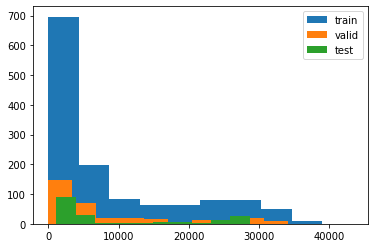

In [19]:
plt.hist(train_y_early, label = 'train')
plt.hist(valid_y_early, label = 'valid')
plt.hist(test_pred, label = 'test')
plt.legend()

In [20]:
imp = reg1.feature_importances_
features = train_x_early.columns

importance_df = pd.DataFrame({'feature': features, 'importance': imp})

In [21]:
importance_df.sort_values(by = 'importance', ascending = False)

,feature,importance
0,segment,5.387363e-01
4,application_Day,1.580334e-01
16,application_day_month_cos,1.105424e-01
13,application_Elapsed,8.380830e-02
17,application_day_month_sin,3.823224e-02
21,application_day_year_sin,1.289372e-02
1,application_Year,1.119582e-02
7,application_Is_month_end,8.851830e-03
5,application_Dayofweek,8.593521e-03
6,application_Dayofyear,6.261367e-03
